In [2]:
# Import required libraries
import os
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
pd.options.display.float_format = '{:,.4f}'.format
from pandas_datareader.data import Options 
#from py_vollib.black_scholes_merton.implied_volatility import *
#from py_vollib.black_scholes_merton.greeks.analytical import *

#import urllib.request as req
from scipy.stats import norm as norm

In [3]:
def d1(options_df, interest_rate = 0.0193, q = 0, year = 252):
    numerator = np.log(options_df['Underlying_Price'] / 
                       options_df['Strike']) + ((interest_rate - q) + options_df['IV']**2 / 2.0) * options_df['DTE']/year
    denominator = options_df['IV'] * np.sqrt(options_df['DTE']/year)
    return numerator / denominator

def d2(options_df, interest_rate = 0.0193, q = 0, year = 252):
    return d1(options_df, interest_rate, q, year) - options_df['IV'] * np.sqrt(options_df['DTE']/year)

def bsm_call(options_df, interest_rate = 0.0193, q = 0, year = 252):

    D1 = d1(options_df, interest_rate, q, year)
    D2 = d2(options_df, interest_rate, q, year)
    call_prices = options_df['Underlying_Price'] * np.exp(-q * options_df['DTE']/year) * norm.cdf(D1) - options_df['Strike'] * np.exp(-interest_rate * options_df['DTE']/year) * norm.cdf(D2)
    
    return pd.DataFrame(call_prices)

def bsm_put(options_df, interest_rate = 0.0193, q = 0, year = 252):

    D1 = d1(options_df, interest_rate, q, year)
    D2 = d2(options_df, interest_rate, q, year)
    put_prices = options_df['Strike'] * np.exp(-interest_rate * options_df['DTE']/year) * norm.cdf(-D2) - options_df['Underlying_Price'] * np.exp(-q * options_df['DTE']/year) * norm.cdf(-D1)
    return pd.DataFrame(put_prices)

def black_scholes_merton(options_df, interest_rate = 0.0193, q = 0, year = 252):
    calls = options_df[options_df['Type'] == 'call']
    if len(calls) > 0:
        calls['Simulated Prices'] = bsm_call(calls, interest_rate, q, year)
    
    
    puts = options_df[options_df['Type'] == 'put']
    if len(puts) > 0:
        puts['Simulated Prices'] = bsm_put(puts, interest_rate, q, year)
    
    if len(puts) > 0 and len(calls) > 0:
        df = pd.concat([calls, puts], axis = 0)
    elif len(puts) > 0:
        df = puts
    else:
        df = calls
        
    return df.fillna(0).reset_index()[df.columns]

def delta(options_df, interest_rate = 0.0193, q = 0, year = 252):

    options_df['D1'] = d1(options_df, interest_rate, q, year)
    calls = options_df[options_df['Type'] == 'call']
    if len(calls) > 0:
        calls['Delta'] = np.exp(-q*calls['DTE']/year)*norm.cdf(calls['D1'])
    
    puts = options_df[options_df['Type'] == 'put']
    if len(puts) > 0:
        puts['Delta'] = -np.exp(-q*puts['DTE']/year)*norm.cdf(-puts['D1'])
    
    if len(puts) > 0 and len(calls) > 0:
        df = pd.concat([calls, puts], axis = 0)
    elif len(puts) > 0:
        df = puts
    else:
        df = calls
        
    del df['D1']
    return df.fillna(0).reset_index()[df.columns]

def theta(options_df, interest_rate = 0.0193, q = 0, year = 252):

    options_df['D1'] = d1(options_df, interest_rate, q, year)
    options_df['D2'] = d2(options_df, interest_rate, q, year)

    options_df['first_term'] = (options_df['Underlying_Price'] * np.exp(-q * options_df['DTE']/year) * 
                                norm.pdf(options_df['D1']) * options_df['IV']) / (2 * np.sqrt(options_df['DTE']/year))
    
    calls = options_df[options_df['Type'] == 'call']
    if len(calls) > 0:
        calls_second_term = -q * calls.Strike * np.exp(-q * calls.DTE/year)*norm.cdf(calls.D1)
        calls_third_term = interest_rate * calls.Strike * np.exp(-interest_rate * calls.DTE/year)*norm.cdf(calls.D2)
        calls['Theta'] = -(calls.first_term + calls_second_term + calls_third_term) / 365.0
    
    puts = options_df[options_df['Type'] == 'put']
    if len(puts) > 0:
        puts_second_term = -q * puts.Strike * np.exp(-q * puts.DTE/year) * norm.cdf(-puts.D1)
        puts_third_term = interest_rate * puts.Strike * np.exp(-interest_rate * puts.DTE/year) * norm.cdf(-puts.D2)
        puts['Theta'] = (-puts.first_term + puts_second_term + puts_third_term) / 365.0
    
    if len(puts) > 0 and len(calls) > 0:
        df = pd.concat([calls, puts], axis = 0)
    elif len(puts) > 0:
        df = puts
    else:
        df = calls
        
    del df['first_term'], df['D1'], df['D2']
    
    return df.fillna(0).reset_index()[df.columns]


def gamma(options_df, interest_rate = 0.0193, q = 0, year = 252):
    D1 = d1(options_df, interest_rate, q, year)
    numerator = np.exp(-q * options_df.DTE/year) * norm.pdf(D1)
    denominator = options_df.Underlying_Price * options_df.IV * np.sqrt(options_df.DTE/year)
    options_df['Gamma'] = numerator / denominator
    return options_df.fillna(0)


def vega(options_df, interest_rate = 0.0193, q = 0, year = 252):
    D1 = d1(options_df, interest_rate, q, year)
    options_df['Vega'] = options_df.Underlying_Price * np.exp(-q * options_df.DTE/year) * norm.pdf(D1) * np.sqrt(options_df.DTE/year) * 0.01
    return options_df.fillna(0)


def rho(options_df, interest_rate = 0.0193, q = 0, year = 252):
    options_df['D2'] = d2(options_df, interest_rate, q, year)
    calls = options_df[options_df['Type'] == 'call']
    if len(calls) > 0:
        calls['Rho'] = calls.DTE/year * calls.Strike * np.exp(-interest_rate * calls.DTE/year) * norm.cdf(calls.D2) * 0.01
    
    puts = options_df[options_df['Type'] == 'put']
    if len(puts) > 0:
        puts['Rho'] = -puts.DTE/year * puts.Strike * np.exp(-interest_rate * puts.DTE/year) * norm.cdf(-puts.D2) * 0.01
    
    if len(puts) > 0 and len(calls) > 0:
        df = pd.concat([calls, puts], axis = 0)
    elif len(puts) > 0:
        df = puts
    else:
        df = calls
        
    del df['D2']
    
    return df.fillna(0).reset_index()[df.columns]

def all_greeks(options_df, interest_rate = 0.02493, q = 0, day_format = 'calendar'):
    if day_format != 'trading':
        year = 365
    else:
        year = 252
        
    df = delta(theta(gamma(vega(rho(options_df, interest_rate, q ,year), 
                                interest_rate, q, year),interest_rate, q, year), interest_rate, q, year), interest_rate, q, year)
    # del df['D2']
    return df

#%%

def all_options(ticker, dte_ub, dte_lb, moneyness = 0.03):
    tape = Options(ticker, 'yahoo')
    data = tape.get_all_data().reset_index()
    
    data['Moneyness'] = np.abs(data['Strike'] - data['Underlying_Price'])/data['Underlying_Price']
    
    data['DTE'] = (data['Expiry'] - dt.datetime.today()).dt.days
    data = data[['Strike', 'Expiry','DTE', 'Type', 'IV', 'Underlying_Price',
                 'Last','Bid','Ask', 'Moneyness']]
    data['Mid'] = (data['Ask'] - data['Bid'])/2 + data['Bid']
    data = data.dropna()
    data = data[(abs(data['Moneyness']) <= moneyness) &
                (data['DTE'] <= dte_ub) &
                (data['DTE'] >= dte_lb)]
    return data.sort_values(['DTE','Type']).reset_index()[data.columns]

def price_sim(options_df, price_change, vol_change, days_change, output = 'All',
              skew = 'flat', day_format = 'trading', interest_rate = 0.0193, q = 0,
              prem_price_use = 'Mid'):
    '''
    output types can be: All, Price, Delta, Gamma, Vega, Theta
    skew types can be: flat, left, right, smile
    '''
    if prem_price_use != 'Mid':
        price_col = 'Last'
    else:
        price_col = 'Mid'
        
    if day_format != 'trading':
        year = 365
    else:
        year = 252
    
    df = options_df.copy()
    df['Underlying_Price'] = df['Underlying_Price']*(1 + price_change)
    df['DTE'] = df['DTE'] - days_change
    df[df['DTE'] < 0] = 0
    
    
    if skew == 'flat':
        df['IV'] = df['IV'] + vol_change
    elif skew == 'right':
        df['IV'] = df['IV'] + vol_change + vol_change*(df['Strike']/df['Underlying_Price'] - 1)
    elif skew == 'left':
        df['IV'] = df['IV'] + vol_change - vol_change*(df['Strike']/df['Underlying_Price'] - 1)
    else:
        df['IV'] = df['IV'] + vol_change + vol_change*abs(df['Strike']/df['Underlying_Price'] - 1)
            
    output_df = black_scholes_merton(delta(gamma(theta(vega(rho(df,interest_rate, q, year), 
                                                           interest_rate, q, year),
                                                      interest_rate, q, year), 
                                                interest_rate, q, year), 
                                          interest_rate, q, year),
                                     interest_rate, q, year)
    return output_df

def position_sim(position_df, holdings, shares,
                 price_change, vol_change, dte_change, output = 'All',
                 skew = 'flat', prem_price_use = 'Mid', day_format = 'trading', 
                 interest_rate = 0.0193, dividend_rate = 0, vol_spacing = 2,
                 spacing = 20):
    
    if prem_price_use != 'Mid':
        price_col = 'Last'
    else:
        price_col = 'Mid'

    position = position_df.copy().reset_index()[['Strike','Expiry','DTE','Type','IV','Underlying_Price',price_col]]
    position['Pos'] = holdings
    initial_cost = sum(position[price_col]*position['Pos'])*100 + shares*position['Underlying_Price'].values[0]
    
    price_changes = np.linspace(price_change[0], price_change[-1], spacing)
    dte_changes = np.linspace(dte_change[0], dte_change[-1], dte_change[-1] - dte_change[0] + 1)

    if vol_spacing <= 2:
        vol_changes = vol_change
    else:
        vol_changes = np.linspace(vol_change[0], vol_change[-1], vol_spacing)

    adj_dfs = []

    price_ax, dte_ax = np.meshgrid(price_changes,dte_changes)

    vol_adj_df = pd.DataFrame(np.array(np.meshgrid(price_changes,dte_changes)).reshape(2,-1).T)
    vol_adj_df.columns = ['ret_change', 'dte_change']

    for vol_change in vol_changes:
        # mesh_shape = np.meshgrid(price_changes,dte_changes)

        indi_sims = []
        for idx, row in position.iterrows():
            curr_sim = pd.DataFrame(index = range(len(vol_adj_df)))
            curr_sim['Strike'] = row.Strike
            curr_sim['DTE'] = row.DTE - vol_adj_df['dte_change']
            curr_sim[curr_sim['DTE'] < 0] = 0

            curr_sim['Type'] = row.Type
            curr_sim['IV'] = row.IV
            curr_sim['Underlying_Price'] = (1 + vol_adj_df[['ret_change']])*row.Underlying_Price
            curr_sim = price_sim(curr_sim, 0, vol_change, 0, output,
                                 skew, day_format, interest_rate, dividend_rate,
                                 prem_price_use)
            indi_sims.append(curr_sim)

        if len(holdings) < 2:
            try:
                adj_df = indi_sims[0].copy()
            except:
                break
            adj_df['Delta'] = adj_df['Delta'] + shares/100
            adj_df['PnL'] = position.head(1)['Pos'][0]*(adj_df['Simulated Prices'] - 
                                                        position.head(1)[price_col][0])*100 + shares*(adj_df['Underlying_Price'] - 
                                                                                                      position.head(1)['Underlying_Price'][0])
        else:
            adj_df = curr_sim[['Underlying_Price']]
            adj_df['Delta'] = 0
            adj_df['Gamma'] = 0
            adj_df['Vega'] = 0
            adj_df['Theta'] = 0
            adj_df['Rho'] = 0
            adj_df['PnL'] = 0
            for i, val in enumerate(holdings):
                adj_df['Delta'] = adj_df['Delta'] + val*indi_sims[i]['Delta']
                adj_df['Gamma'] = adj_df['Gamma'] + val*indi_sims[i]['Gamma']
                adj_df['Vega'] = adj_df['Vega'] + val*indi_sims[i]['Vega']
                adj_df['Theta'] = adj_df['Theta'] + val*indi_sims[i]['Theta']
                adj_df['Rho'] = adj_df['Rho'] + val*indi_sims[i]['Rho']
                adj_df['PnL'] = adj_df['PnL'] + val*indi_sims[i]['Simulated Prices']

            adj_df['PnL'] = (adj_df['PnL'] - sum(position[price_col]*position['Pos']))*100 + shares*(adj_df['Underlying_Price'] -
                                                                                                     position.head(1)['Underlying_Price'][0])
        if initial_cost < 0:
            adj_df['Percent Return'] = adj_df['PnL']/(-initial_cost)
        else:
            adj_df['Percent Return'] = adj_df['PnL']/initial_cost
        adj_df['Date'] = dt.datetime.today().date() + pd.to_timedelta(vol_adj_df['dte_change'] + 1, 'd')
        adj_dfs.append(adj_df)
    
    return (adj_dfs, price_ax, dte_ax)

In [4]:
def surface_plot(adj_dfs,priceGrid,dteGrid,v_changes, display = 'PnL'):

    
    surface1 = go.Surface(x = (priceGrid + 1)*yahoo_data['Underlying_Price'].values[0], 
                          y = dteGrid, 
                          z = np.array(adj_dfs[0][display]).reshape(priceGrid.shape),
                          name = 'Vol Change of {}%'.format(round(v_changes[0]*100),2))

    surface2 = go.Surface(x = (priceGrid + 1)*yahoo_data['Underlying_Price'].values[0], 
                          y = dteGrid, 
                          z = np.array(adj_dfs[1][display]).reshape(priceGrid.shape),
                          name = 'Vol Change of {}%'.format(round(v_changes[1]*100),2))

    layout = go.Layout(
                title='{} Plot'.format(display),
                autosize=True,
                showlegend = False,
                scene=dict(
                    aspectmode = 'manual',
                    aspectratio = dict(x = 2,
                                       y = 2,
                                       z = 1),
                    camera = dict(up = dict(x = 0,
                                            y = 0,
                                            z = 1),
                                  center = dict(x = 0,
                                                y = 0,
                                                z = 0),
                                  eye = dict(x = 1,
                                             y = 1,
                                             z = 0.5)),
                    xaxis=dict(
                        title='Underlying Price',
                        gridcolor='rgb(255, 255, 255)',
                        zerolinecolor='rgb(255, 255, 255)',
                        showbackground=True,
                        backgroundcolor='rgb(230, 230,230)'
                    ),
                    yaxis=dict(
                        title='DTE Change',
                        gridcolor='rgb(255, 255, 255)',
                        zerolinecolor='rgb(255, 255, 255)',
                        showbackground=True,
                        backgroundcolor='rgb(230, 230,230)'
                    ),
                    zaxis=dict(
                        title = display,
                        gridcolor='rgb(255, 255, 255)',
                        zerolinecolor='rgb(255, 255, 255)',
                        showbackground=True,
                        backgroundcolor='rgb(230, 230,230)'
                    )
                )
            )

    data = [surface1, surface2]
    figure = dict(data=data, layout=layout)
    return figure

In [5]:
ticker = '^GSPC'
dte_ub = 90
dte_lb = 10
moneyness = 0.1
interest_rate = 0.02493
shares = 0


yahoo_data = all_options(ticker, dte_ub, dte_lb, moneyness)



In [6]:
table = all_greeks(yahoo_data).reset_index(drop = True)

In [7]:
table[(table.DTE == 41) & (table.Type == 'put') & (table.Strike < table.Underlying_Price)]

,Strike,Expiry,DTE,Type,IV,Underlying_Price,Last,Bid,Ask,Moneyness,Mid,Rho,Vega,Gamma,Theta,Delta


In [7]:
position_df = table.iloc[[385]]#table.iloc[[385,416,425]]
holdings = [1]
shares = 0
price_change = [-0.2, 0.2]
vol_change = [-0.3, 0.3]
dte_change = [1, 41]
position_df

,Strike,Expiry,DTE,Type,IV,Underlying_Price,Last,Bid,Ask,Moneyness,Mid,Rho,Vega,Gamma,Theta,Delta
385,"2,535.0000",2019-03-15,53,put,0.1915,"2,670.7100",25.8000,26.5000,27.0000,0.0508,26.7500,-0.8560,2.9466,0.0015,-0.4921,-0.2117


In [8]:
adj_dfs,priceGrid,dteGrid = position_sim(position_df, holdings, shares,
                 price_change, vol_change, dte_change, output = 'All',
                 skew = 'flat', prem_price_use = 'Mid', day_format = 'trading', 
                 interest_rate = 0.02493, dividend_rate = 0, vol_spacing = 2,
                 spacing = 20)

In [9]:
np.array(adj_dfs[0]['Gamma']).reshape(priceGrid.shape)

array([[ -1.42795387e-05,  -7.04602885e-05,  -2.55559283e-04,
         -6.96291412e-04,  -1.45365248e-03,  -2.36803228e-03,
         -3.06058324e-03,  -3.18679061e-03,  -2.71111739e-03,
         -1.90907208e-03,  -1.12609741e-03,  -5.62622110e-04,
         -2.40544585e-04,  -8.88461012e-05,  -2.86006037e-05,
         -8.09032186e-06,  -2.02638835e-06,  -4.52618038e-07,
         -9.07552081e-08,  -1.64372466e-08],
       [ -1.28154015e-05,  -6.53665568e-05,  -2.43587223e-04,
         -6.78031759e-04,  -1.43856722e-03,  -2.36994179e-03,
         -3.08352368e-03,  -3.21834946e-03,  -2.73356040e-03,
         -1.91460232e-03,  -1.11940160e-03,  -5.52526500e-04,
         -2.32658388e-04,  -8.43898437e-05,  -2.66056047e-05,
         -7.35186552e-06,  -1.79449118e-06,  -3.89718827e-07,
         -7.58163319e-08,  -1.32958413e-08],
       [ -1.14494081e-05,  -6.04470772e-05,  -2.31683934e-04,
         -6.59415957e-04,  -1.42275646e-03,  -2.37144905e-03,
         -3.10693496e-03,  -3.25084389e-03

In [10]:
fig = surface_plot(adj_dfs,priceGrid,dteGrid,vol_change, 'Theta')

iplot(fig)

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

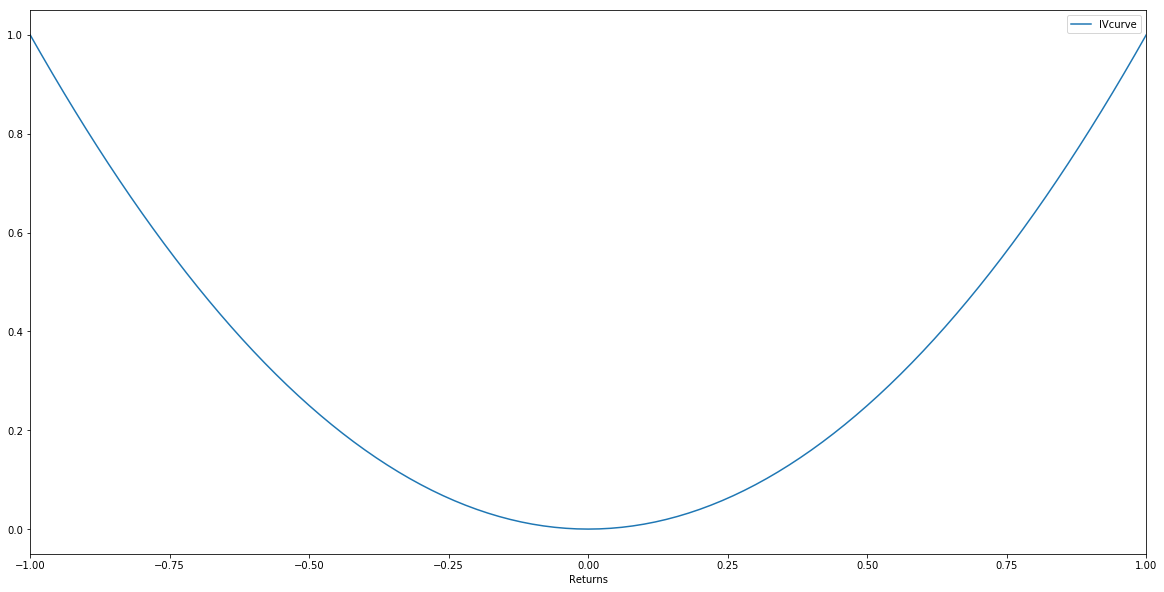

In [46]:
rets = pd.DataFrame({'Returns': np.linspace(-1,1,201)})

scale_factor = 1
shift_factor = 0

rets['IVcurve'] = (scale_factor*abs(rets.Returns - shift_factor)*100)**2/10000 - (scale_factor*abs(shift_factor)*100)**2/10000

rets.set_index('Returns').plot(figsize = (20,10))

